# iESPnet inference with ensemble learning

In [1]:
import torch
from torch import nn
import numpy as np
import os
from matplotlib import pyplot as plt
import torchaudio.transforms as T
from scipy import fft as sp_fft
from scipy import stats
import librosa
import sys
sys.path.insert(1, 'X:/iESPnet/iESPnet_SRC/utilities')
from Model import iESPnet
import pandas as pd
from numpy.linalg import norm 
from numpy import average


In [2]:
def compute_wae(outputs, weights):
    # post process the output given the threshold
    predicted_av = average(outputs, axis = 0, weights = weights)
    
    y_torch = torch.from_numpy(predicted_av)
    n = torch.nn.Threshold(thr, 0)
    y_predicted = n(y_torch)    
    
    if len(y_predicted.shape)>1:
        l_predicted = np.zeros((len(y_predicted,)))
        t_predicted_samples =  np.zeros((len(y_predicted,)))
        idx_predicted = np.where(y_predicted.sum(dim=1)>0.0)[0].tolist()
        l_predicted[idx_predicted] = 1  
        t_predicted_samples[idx_predicted] = y_predicted[idx_predicted].argmax(dim=1).numpy()
        t_predicted_samples = t_predicted_samples.astype(int)
    else:
        if y_predicted.sum()>0.0:
            l_predicted = 1  
            t_predicted_samples = y_predicted.argmax().numpy()
            t_predicted_samples = t_predicted_samples.astype(int)
        else:
            l_predicted = 0
            t_predicted_samples = 0
            
    ECOG_SAMPLE_RATE =250
    TT = 1000 # window length
    overlap = 500 #
    win_len = int(ECOG_SAMPLE_RATE * TT / 1000 ) # win size
    hop_len = int(ECOG_SAMPLE_RATE * (TT - overlap) / 1000)   # Length of hop between windows.
    fs=250
    shape = 22500
    time = np.arange(win_len/2, shape + win_len/2 + 1,
                         win_len - (win_len-hop_len))/float(fs)
    time -= (win_len/2) / float(fs)
    
    t_predicted = time[t_predicted_samples]
    return l_predicted, t_predicted, y_predicted

#### Define hyperparameters and paths

In [3]:
# do not change this 
FREQ_MASK_PARAM = 10
TIME_MASK_PARAN = 20
N_CLASSES = 1
learning_rate = 1e-3
batch_size = 128
epochs = 20
num_workers = 4
top_db = 40.0
thr = 0.2
# to load PITT models - this is saved in Nexus2
pit_subject_info = 'X:/iESPnet/Data/Metadatafiles/subjects_info_zeropadall_nothalamus.csv'
pit_df_subjects = pd.read_csv(pit_subject_info)
# list of PITT models
RNSIDS_PIT=pit_df_subjects.rns_deid_id
# location of saved PITT models - this is saved in Nexus2
save_path = 'X:/iESPnet/Models/PITT/' 

### Model Definition

In [4]:
hparams = {
        "n_cnn_layers": 3,
    "n_rnn_layers": 3,
    "rnn_dim": [150, 100, 50],
    "n_class": N_CLASSES,
    "out_ch": [8,8,16],
    "dropout": 0.3,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "num_workers": num_workers,
    "epochs": epochs
}
model = iESPnet(hparams['n_cnn_layers'],
                       hparams['n_rnn_layers'],
                       hparams['rnn_dim'],
                       hparams['n_class'],
                       hparams['out_ch'],
                       hparams['dropout'],
                       )

### Example Inference using .npy example spectrogram

In [5]:
example_batch = r"X:\iESPnet\Data\RNS_Databank_Spectrograms\TimeLabelZeropadAll\MGH\MGH_RNS0259_20180808-1_E0.npy"
dat_np = np.load(example_batch, allow_pickle=True)
dat_np_arr = dat_np.item()["spectrogram"]

dat_np_arr = np.expand_dims(dat_np_arr, axis=0)  # Shape for batch inference

In [6]:
dat_np_arr.shape

(1, 4, 120, 181)

In [29]:
# define the time vector accordigly to the spectrograms parameters definitions
ECOG_SAMPLE_RATE =250
TT = 1000 # window length
overlap = 500 #
win_len = int(ECOG_SAMPLE_RATE * TT / 1000 ) # win size
hop_len = int(ECOG_SAMPLE_RATE * (TT - overlap) / 1000)   # Length of hop between windows.
fs=250
shape = 22500
time = np.arange(win_len/2, shape + win_len/2 + 1,
                     win_len - (win_len-hop_len))/float(fs)
time -= (win_len/2) / float(fs)

Text(0.5, 1.0, 'Input Spectrogram')

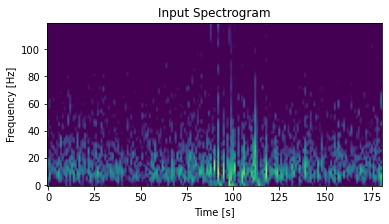

In [30]:
plt.figure(figsize=(6, 3))
plt.imshow(dat_np_arr[0, 0, :, : ], aspect="auto")
plt.gca().invert_yaxis()
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Input Spectrogram")

### Make model prediction

In [27]:
# get the output for every PITT model
y_probs = []
for ss in range(len(RNSIDS_PIT)):
    model_path = save_path + RNSIDS_PIT[ss] +'/models/model_opt.pth'
    # load model
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(torch.device('cpu'))
    model = model.float()
    # put the model in eval mode
    model.eval()
    with torch.no_grad():
        dat_np_arr = dat_np_arr.astype(np.double)
        x = torch.from_numpy(dat_np_arr)
        outputs = model(x.float())

        m = nn.Sigmoid()

        probs = m(outputs)
    y_probs.append(probs.numpy())

In [28]:
print(np.shape(y_probs))

(24, 181)


In [10]:
# compute the weight vector for the averaging
weights = []
for ss in range(len(RNSIDS_PIT)):
    # get results to compute weigth
    save_predictions_pitt = save_path + RNSIDS_PIT[ss]+'/results/'   
    results =  np.load(save_predictions_pitt+ RNSIDS_PIT[ss]+ 'results.npy', allow_pickle = True)
    results = results.tolist()


    prediction_te = results['prediction_te']
    subject_df = pit_df_subjects[pit_df_subjects.rns_deid_id==RNSIDS_PIT[ss]]
    q = subject_df.Nsz/subject_df.Nfiles

    p = (subject_df.Nfiles-subject_df.Nsz)/subject_df.Nfiles
    F1_coin = np.array(2*q/(q+1))

    we = (prediction_te['f1']-F1_coin)/F1_coin/100
    weights.append(we)

weights_n = weights/norm(weights,1)
weights = np.squeeze(np.array(weights))
weights[weights<0.0]=0.0

In [32]:
# run the ensemble
estimated_label, estimated_time, estimated_output = compute_wae(y_probs, weights)  #weighted average ensemble

(0.0, 1.0)

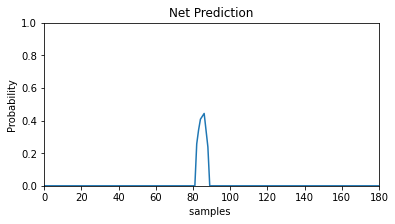

In [34]:
#visualize prediction
plt.figure(figsize=(6, 3))
plt.plot(estimated_output)
plt.xlabel("samples ")
plt.xlim(0, 180)
plt.title("Net Prediction")
plt.ylabel("Probability")
plt.ylim(0, 1)

In [37]:
print('The estimated label is ' + str(estimated_label) + ' with onset: ' + str(estimated_time) + 's')

The estimated label is 1 with onset: 43.0s


### Inference based on a time series

The following example illustrates the spectrogram generation based on an poission distribution time series and the net inference.

In [14]:
# define a 90s length data segment
TIME_LENGTH = 90
fs = 250

time_series_example = np.array(
    [
        np.random.poisson(1, int(fs * TIME_LENGTH))
        for _ in range(4)
    ]
)

In [15]:
# if the time series is shorther than 90 s pad the file
time_to_pad = int(TIME_LENGTH* fs) - len(time_series_example.T) # in samples
n_samples = int(round((TIME_LENGTH)*fs))

if time_to_pad > 0:

    # using zeros
    pad_data = np.zeros((4, time_to_pad))
    time_series_example = np.concatenate((time_series_example,pad_data),1)
    # now extract only the data fit to the frame
    time_series_example = time_series_example[:, :n_samples]


In [16]:
time_series_example.shape

(4, 22500)

Text(0.5, 1.0, 'Example poisson noise time trace')

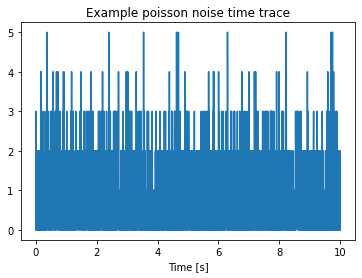

In [17]:
plt.plot(np.arange(0, 10, 0.004), time_series_example[0, :2500])
plt.xlabel("Time [s]")
plt.title("Example poisson noise time trace")

### Construct Spectrogram

In [18]:
# define spectrograms parameters
n_fft = 500
fs = 250
TT = 1000 # window length
overlap = 500
win_len = int(fs * TT / 1000 ) # win size
hop_len = int(fs * (TT - overlap) / 1000)   # Length of hop between windows.
power = 2.0
top_db = 40.0

wind_dic={
    'periodic':True,
    'beta':10
}
           
spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_len,
                            hop_length=hop_len, pad=0,
                            window_fn =torch.kaiser_window,
                            normalized=False,
                            power=power, wkwargs=wind_dic)
# normalize
signal = stats.zscore(time_series_example.T)


time = np.arange(win_len/2, signal.shape[-1] + win_len/2 + 1,
                    win_len - (win_len-hop_len))/float(fs)
time -= (win_len/2) / float(fs)
freqs = sp_fft.rfftfreq(n_fft, 1/fs)
out_ = spectrogram(torch.from_numpy(signal.T))

spec = librosa.power_to_db(out_, top_db=top_db)
# save up to 60 Hz
idx_60 = np.where(freqs<= 60)[0][-1]
spec = spec[:, :idx_60,:]

In [19]:
spec.shape

(4, 120, 181)

Text(0.5, 1.0, 'Input Spectrogram')

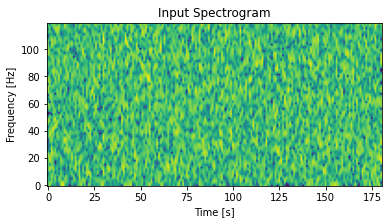

In [20]:
plt.figure(figsize=(6, 3))
plt.imshow(spec[0, :, :], aspect="auto")
plt.gca().invert_yaxis()
plt.xlabel("samples ")
plt.ylabel("Frequency [Hz]")
plt.title("Input Spectrogram")

In [21]:
# get the output for every PITT model
y_probs = []
# 
spec = spec.astype(np.double)
spec = np.expand_dims(spec, axis=0)
for ss in range(len(RNSIDS_PIT)):
    model_path = save_path + RNSIDS_PIT[ss] +'/models/model_opt.pth'
    # load model
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(torch.device('cpu'))
    model = model.float()
    # put the model in eval mode
    model.eval()
    with torch.no_grad():
        
        x = torch.from_numpy(spec)
        outputs = model(x.float())

        m = nn.Sigmoid()

        probs = m(outputs)
    y_probs.append(probs.numpy())

In [22]:
# compute the weight vector for the averaging
weights = []
for ss in range(len(RNSIDS_PIT)):
    # get results to compute weigth
    save_predictions_pitt = save_path + RNSIDS_PIT[ss]+'/results/'   
    results =  np.load(save_predictions_pitt+ RNSIDS_PIT[ss]+ 'results.npy', allow_pickle = True)
    results = results.tolist()


    prediction_te = results['prediction_te']
    subject_df = pit_df_subjects[pit_df_subjects.rns_deid_id==RNSIDS_PIT[ss]]
    q = subject_df.Nsz/subject_df.Nfiles

    p = (subject_df.Nfiles-subject_df.Nsz)/subject_df.Nfiles
    F1_coin = np.array(2*q/(q+1))

    we = (prediction_te['f1']-F1_coin)/F1_coin/100
    weights.append(we)

weights_n = weights/norm(weights,1)
weights = np.squeeze(np.array(weights))
weights[weights<0.0]=0.0

In [23]:
# run the ensemble
estimated_label, estimated_time, estimated_output = compute_wae(y_probs, weights)  #weighted average ensemble

(0.0, 1.0)

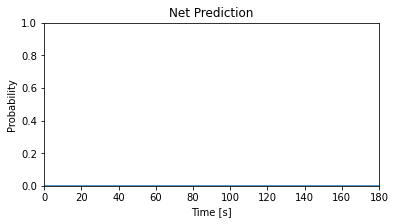

In [24]:
plt.figure(figsize=(6, 3))
plt.plot(probs)
plt.xlabel("Samples")
plt.xlim(0, 180)
plt.title("Net Prediction")
plt.ylabel("Probability")
plt.ylim(0, 1)

In [25]:
print('The estimated label is ' + str(estimated_label) + ' with onset: ' + str(estimated_time) + 's')

The estimated label is 0 with onset: 0.0
